# Read Data

In [2]:
import json

In [3]:
# llamaparse ballanced
with open('fixed_res/GT/benchmark_data.md', encoding='utf8') as f:
    benchmark_md = f.read()

benchmark_data = []
for page in benchmark_md.split("\n\n---\n\n"):
    if page.strip():
        benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-AF24_Alexander_Redman_Final.pdf.md', encoding='utf8') as f:
    redman_benchmark_md = f.read()

redman_benchmark_data = []
for page in redman_benchmark_md.split("\n\n---\n\n"):
    if page.strip():
        redman_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-attention_paper.pdf.md', encoding='utf8') as f:
    attention_benchmark_md = f.read()

attention_benchmark_data = []   
for page in attention_benchmark_md.split("\n---\n"):
    if page.strip():
        attention_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-Astra_AR_2023 (15052024)_LR-1-220.pdf.md', encoding='utf8') as f:
    astra_ar_220_benchmark_md = f.read()

astra_ar_220_benchmark_data = []
for page in astra_ar_220_benchmark_md.split("\n---\n"):
    if page.strip():
        astra_ar_220_benchmark_data.append({"markdown": page.strip()})

with open('fixed_res/GT/benchmark-AR for improved learnability.pdf.md', encoding='utf8') as f:
    ar_benchmark_md = f.read()

ar_benchmark_data = []
for page in ar_benchmark_md.split("\n---\n"):
    if page.strip():
        ar_benchmark_data.append({"markdown": page.strip()})

combined_benchmark_data = benchmark_data + redman_benchmark_data + attention_benchmark_data + astra_ar_220_benchmark_data + ar_benchmark_data
len(combined_benchmark_data)

314

# Load Requirements

In [10]:
# !pip install torchmetrics python-Levenshtein

In [16]:
# Character Error rate (CER)
from torchmetrics.text import CharErrorRate
from torchmetrics.text import WordErrorRate
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text import BLEUScore
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
import Levenshtein
import tqdm

cer = CharErrorRate()
wer = WordErrorRate()
rouge = ROUGEScore()
bleu_1 = BLEUScore(n_gram=1)
bleu_2 = BLEUScore(n_gram=2)
bleu_3 = BLEUScore(n_gram=3)
bleu_4 = BLEUScore(n_gram=4)

In [17]:
def get_normalized_edit_distance(s1, s2):
    edit_distance = Levenshtein.distance(s1, s2)
    return edit_distance / max(len(s1), len(s2))

In [18]:
# Order Score
from difflib import SequenceMatcher
from scipy.stats import kendalltau, spearmanr
import re
import numpy as np

def split_into_blocks(text):
    # Basic split: by double newlines (paragraph/section boundaries)
    blocks = [block.strip() for block in text.strip().split('\n') if block.strip()]
    # remove empty blocks and blocks with only whitespace
    blocks = [block for block in blocks if block and not re.match(r'^\s*$', block)]
    return blocks

def get_block_order_indices(pred_blocks, target_blocks):
    indices = []
    indices_score = []
    for j, t_block in enumerate(target_blocks):
        sequence_score = []
        for i, p_block in enumerate(pred_blocks):
            score = SequenceMatcher(None, t_block, p_block).ratio()
            sequence_score.append(score)
        if sequence_score:
            max_index = sequence_score.index(max(sequence_score))
            indices.append(max_index)
            indices_score.append(max(sequence_score))
    return indices, indices_score

def order_score_predict(pred_text, target_text):
    pred_blocks = split_into_blocks(pred_text)
    target_blocks = split_into_blocks(target_text)

    target_indices = list(range(len(target_blocks)))
    pred_indices, _ = get_block_order_indices(pred_blocks, target_blocks)

    if sum(pred_indices) == 0:
        return 0.0, 0.0  # not enough data to compare order
    
    tau, _ = kendalltau(target_indices, pred_indices)
    # spearman = spearmanr(target_indices, pred_indices)[0]
    spearman = 99

    # if nan print the values
    if np.isnan(tau) or np.isnan(spearman):
        # print(f"target_indices: {target_indices}, \npred_indices: {pred_indices}")
        return 0.0, 0.0

    return max(tau, 0), max(spearman, 0)  # ensure non-negative

In [21]:
import numpy as np
import pandas as pd

# benchmarking function
def benchmark(benchmark_pages, parser_pages, type="markdown"):
    cer_scores = []
    wer_scores = []
    # rouge_scores = []
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    tau_scores = []
    # spearman_scores = []
    # meteor_scores = []
    # ned_scores = []
    # for i, page in enumerate(benchmark_pages):
    for i in tqdm.tqdm(range(len(benchmark_pages))):
        target = benchmark_pages[i]['markdown']
        preds = parser_pages[i][type]

        # cer score
        cer_score = cer(preds=preds, target=target).item()
        cer_scores.append(round(cer_score, 4))

        # wer score
        wer_score = wer(preds=preds, target=target).item()
        wer_scores.append(round(wer_score, 4))

        # rouge score
        # rouge_score = rouge(preds=preds, target=target)
        # rougeL_recall = rouge_score["rougeL_recall"].item()
        # rouge_scores.append(round(rougeL_recall, 4))

        # bleu score
        bleu_1_score = bleu_1(preds=[preds], target=[[target]]).item()
        bleu_2_score = bleu_2(preds=[preds], target=[[target]]).item()
        bleu_3_score = bleu_3(preds=[preds], target=[[target]]).item()
        bleu_4_score = bleu_4(preds=[preds], target=[[target]]).item()
        bleu_1_scores.append(round(bleu_1_score, 4))
        bleu_2_scores.append(round(bleu_2_score, 4))
        bleu_3_scores.append(round(bleu_3_score, 4))
        bleu_4_scores.append(round(bleu_4_score, 4))

        # order score
        tau_score, spearman_score = order_score_predict(preds, target)
        # handle NaN values
        # if tau_score == 0.0 and spearman_score == 0.0:
        #     print(f"{i} - tau: {tau_score}, spearman: {spearman_score}")

        tau_score = float(tau_score)
        # spearman_score = float(spearman_score)
        tau_scores.append(round(tau_score, 4))
        # spearman_scores.append(round(spearman_score, 4))

        # meteor score
        # tokenize the text into words
        # target_words = word_tokenize(target)
        # preds_words = word_tokenize(preds)
        # meteor_score = single_meteor_score(target_words, preds_words)
        # meteor_scores.append(round(meteor_score, 4))
    
        # normalized edit distance score
        # ned_score = Levenshtein.distance(target, preds) / max(len(target), len(preds))
        # ned_score = float(ned_score)
        # ned_scores.append(round(ned_score, 4))

        # Print scores
        # print(f"CER: {cer_score:.4f}")
        # print(f"WER: {wer_score:.4f}")
        # print(f"METEOR: {meteor_score:.4f}")
        # # print(f"ROUGE: {rougeL_recall:.4f}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print(f"Order Score (Kendall Tau): {tau_score:.4f}")
        # print(f"Order Score (Spearman): {spearman_score:.4f}")
        # print(f"Normalized Edit Distance: {ned_score:.4f}")
        # print()

    # calculate average scores
    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)
    # avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
    avg_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
    avg_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
    avg_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)
    avg_tau = sum(tau_scores) / len(tau_scores)
    # avg_spearman = sum(spearman_scores) / len(spearman_scores)
    # avg_meteor = sum(meteor_scores) / len(meteor_scores)
    # avg_ned = sum(ned_scores) / len(ned_scores)
    
    print(f"CER List: {cer_scores}")
    print(f"Average CER: {avg_cer:.4f}")
    print(f"WER List: {wer_scores}")
    print(f"Average WER: {avg_wer:.4f}")

    # print(f"Meteor List: {meteor_scores}")
    # print(f"Average Meteor: {avg_meteor:.4f}")
    # print(f"ROUGE List: {rouge_scores}")
    # print(f"Average ROUGE: {avg_rouge:.4f}")

    print(f"BLEU 1 List: {bleu_1_scores}")
    print(f"Average BLEU 1: {avg_bleu_1:.4f}")
    print(f"BLEU 2 List: {bleu_2_scores}")
    print(f"Average BLEU 2: {avg_bleu_2:.4f}")
    print(f"BLEU 3 List: {bleu_3_scores}")
    print(f"Average BLEU 3: {avg_bleu_3:.4f}")
    print(f"BLEU 4 List: {bleu_4_scores}")
    print(f"Average BLEU 4: {avg_bleu_4:.4f}")
    print(f"Order Score (Kendall Tau) List: {tau_scores}")
    print(f"Average Order Score (Kendall Tau): {avg_tau:.4f}")

    # print(f"Order Score (Spearman) List: {spearman_scores}")
    # print(f"Average Order Score (Spearman): {avg_spearman:.4f}")
    # print(f"Normalized Edit Distance List: {ned_scores}")
    # print(f"Average Normalized Edit Distance: {avg_ned:.4f}")

    return {
        "cer": cer_scores,
        "wer": wer_scores,
        # "meteor": meteor_scores,
        # "rouge": rouge_scores,
        "bleu_1": bleu_1_scores,
        "bleu_2": bleu_2_scores,
        "bleu_3": bleu_3_scores,
        "bleu_4": bleu_4_scores,
        "tau": tau_scores,
        # "spearman": spearman_scores,
        # "ned": ned_scores
    }

# Our Pipeline

In [22]:
# read json
with open('fixed_res/Ours/dummy-data.pdf.json', encoding='utf8') as f:
    dummy_res = json.load(f)

with open('fixed_res/Ours/AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_res = json.load(f)

with open('fixed_res/Ours/attention_paper.pdf.json', encoding="utf8") as f:
    attention_res = json.load(f)

with open('fixed_res/Ours/Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_res = json.load(f)

with open('fixed_res/Ours/AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_res = json.load(f)

combined_res = dummy_res["pages"].copy() + redman_res["pages"].copy() + attention_res["pages"].copy() + astra_ar_220_res["pages"].copy() + ar_res["pages"].copy()

# benchmarking llamaparse
print("Length data:", len(combined_res))
our_score = benchmark(combined_benchmark_data, combined_res)

Length data: 314


100%|██████████| 314/314 [35:37<00:00,  6.81s/it] 

CER List: [0.1612, 0.4851, 0.1707, 0.4197, 0.0978, 0.7237, 0.0431, 0.672, 0.6787, 1.5298, 0.5441, 0.3622, 0.4972, 0.3668, 0.4284, 0.576, 1.6233, 0.5008, 0.2932, 0.4122, 0.2497, 0.6308, 0.3633, 0.2338, 0.4481, 0.3552, 0.4186, 0.4835, 0.3311, 0.3596, 0.2223, 0.3001, 0.3879, 0.4561, 0.2394, 11.2459, 0.6256, 0.2743, 0.117, 0.3186, 0.4062, 0.5636, 0.7194, 0.352, 0.7112, 0.3318, 0.4563, 0.0993, 0.125, 0.5599, 0.4031, 0.6537, 0.3926, 0.4023, 0.6426, 0.3512, 0.3081, 0.6396, 0.5917, 0.2357, 0.5734, 0.4124, 0.6028, 0.4935, 0.556, 0.4758, 0.1759, 1.2315, 0.5785, 0.1297, 0.0251, 0.0227, 0.3206, 0.3169, 0.0585, 0.141, 0.0468, 0.2585, 0.0635, 0.113, 0.0142, 0.0102, 15.5211, 1.5202, 2.9899, 0.1768, 0.0216, 0.011, 0.5844, 0.244, 0.5832, 0.841, 0.552, 0.0663, 0.4885, 0.4222, 0.4785, 0.6022, 0.5884, 0.6411, 0.5753, 0.5203, 0.0564, 0.4185, 0.3164, 0.1784, 0.3158, 0.1798, 0.1363, 0.1519, 0.3571, 0.0917, 0.2388, 0.3933, 0.3291, 0.3481, 0.5826, 0.1296, 0.0562, 0.5861, 0.126, 0.0194, 0.1593, 0.4308, 0.2082, 

In [23]:
# read json
with open('fixed_res/Ours/dummy-data.pdf.json', encoding='utf8') as f:
    dummy_res = json.load(f)

with open('fixed_res/Ours/AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_res = json.load(f)

with open('fixed_res/Ours/attention_paper.pdf.json', encoding="utf8") as f:
    attention_res = json.load(f)

with open('fixed_res/Ours/Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_res = json.load(f)

with open('fixed_res/Ours/AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_res = json.load(f)

combined_res = dummy_res["pages"].copy() + redman_res["pages"].copy() + attention_res["pages"].copy() + astra_ar_220_res["pages"].copy() + ar_res["pages"].copy()

# benchmarking llamaparse
print("Length data:", len(combined_res))
our_text_score = benchmark(combined_benchmark_data, combined_res, type="text")

Length data: 314


100%|██████████| 314/314 [42:16<00:00,  8.08s/it] 

CER List: [0.2692, 0.6361, 0.1877, 0.398, 0.1587, 0.7262, 0.0769, 0.5578, 0.7192, 1.5348, 0.5475, 0.3672, 0.4849, 0.3636, 0.4321, 0.6389, 1.6609, 0.5013, 0.2947, 0.5373, 0.4717, 0.4645, 0.3674, 0.2366, 0.4557, 0.3595, 0.6297, 0.4786, 0.3366, 0.3672, 0.2167, 0.3006, 0.3919, 0.4561, 0.2464, 3.1557, 0.6289, 0.3726, 0.1371, 0.3426, 0.4078, 0.5659, 0.7177, 0.351, 0.6849, 0.3547, 0.4992, 0.1303, 0.1319, 0.6827, 0.4063, 0.7884, 0.3959, 0.4052, 0.5026, 0.4001, 0.3153, 0.7184, 0.6831, 0.2378, 0.5756, 0.4155, 0.6037, 0.4995, 0.5578, 0.6915, 0.5307, 1.2361, 0.6257, 0.0086, 0.0604, 0.0246, 0.1862, 0.1208, 0.0945, 0.1168, 0.0377, 0.2897, 0.0851, 0.1323, 0.0241, 0.0068, 3.8998, 1.5224, 2.6613, 0.8535, 0.1746, 0.0059, 0.4534, 0.6552, 0.5723, 0.8389, 0.5729, 0.813, 0.4919, 0.4243, 0.7442, 0.5885, 0.5003, 0.6555, 0.5975, 0.5172, 0.1148, 0.163, 0.3164, 0.2302, 0.6842, 0.1788, 0.1385, 0.271, 2.1667, 0.642, 0.4554, 0.4131, 0.3944, 0.3055, 0.4267, 0.1326, 0.0547, 0.1345, 0.1293, 0.0283, 0.3587, 0.7292, 0.4

# LlamaParse

In [24]:
# read json
with open('fixed_res/Llama/llamaparse-dummy_scanned.pdf.json', encoding='utf8') as f:
    llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-attention_paper.pdf.json', encoding="utf8") as f:
    attention_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_llamaparse_res = json.load(f)

with open('fixed_res/Llama/llamaparse-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_llamaparse_res = json.load(f)

combined_llamaparse_res = llamaparse_res["pages"].copy() + redman_llamaparse_res["pages"].copy() + attention_llamaparse_res["pages"].copy() + astra_ar_220_llamaparse_res["pages"].copy() + ar_llamaparse_res["pages"].copy()

# benchmarking llamaparse
print(len(combined_llamaparse_res))
llamaparse_score = benchmark(combined_benchmark_data, combined_llamaparse_res)

314


100%|██████████| 314/314 [1:00:06<00:00, 11.49s/it]

CER List: [0.1313, 0.8655, 0.9166, 0.6936, 0.2182, 0.4328, 0.0431, 0.0064, 0.0918, 0.5753, 0.3374, 0.4211, 0.3501, 0.1998, 0.3258, 0.3952, 0.3043, 0.5111, 0.7517, 0.6005, 0.5593, 0.1596, 0.5841, 0.475, 0.5855, 0.4857, 0.5572, 0.642, 0.6579, 0.3354, 0.5746, 0.7458, 0.5475, 0.6873, 0.5341, 0.2459, 0.4962, 0.75, 0.617, 0.3369, 0.0671, 0.0619, 0.0294, 0.2324, 0.7349, 0.0651, 0.1333, 0.755, 0.1398, 0.789, 0.5989, 0.63, 0.1046, 0.7249, 0.7166, 0.172, 0.3279, 0.7245, 0.6686, 0.5614, 0.7811, 0.3205, 0.7737, 0.6648, 0.715, 0.8765, 0.1125, 0.667, 0.056, 0.0, 0.0934, 0.0014, 0.9813, 0.0018, 0.0095, 0.0008, 0.0, 0.0448, 0.6642, 0.0011, 0.0012, 0.0012, 0.7074, 1.1278, 0.6511, 0.0101, 0.0036, 0.0059, 0.4895, 0.3479, 0.0338, 0.0531, 1.3064, 0.4587, 0.0222, 0.4136, 0.3563, 0.0358, 0.0517, 0.1716, 0.0411, 0.0852, 0.0725, 0.1182, 0.0874, 0.0298, 0.4012, 0.0587, 0.0944, 0.0287, 13.0714, 0.0858, 0.6496, 0.07, 0.2238, 0.3545, 0.4207, 0.3844, 0.5729, 0.5312, 0.0866, 0.0121, 0.6499, 0.7323, 0.4447, 0.3755, 0

In [25]:
# llamaparse ballanced
with open('fixed_res/Llama/llamaparse-balanced-dummy-data.pdf.md', encoding='utf8') as f:
    llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-AF24_Alexander_Redman_Final.pdf.md', encoding='utf8') as f:
    redman_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-attention_paper.pdf.md', encoding='utf8') as f:
    attention_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-Astra_AR_2023 (15052024)_LR-1-220.pdf.md', encoding='utf8') as f:
    astra_ar_220_llamaparse_b_res = f.read()

with open('fixed_res/Llama/llamaparse-balanced-AR for improved learnability.pdf.md', encoding='utf8') as f:
    ar_llamaparse_b_res = f.read()

combined_llamaparse_b_text = llamaparse_b_res + "\n---\n" + redman_llamaparse_b_res + "\n---\n" + attention_llamaparse_b_res + "\n---\n" + astra_ar_220_llamaparse_b_res + "\n---\n" + ar_llamaparse_b_res
combined_llamaparse_b_res = []
for page in combined_llamaparse_b_text.split("\n---\n"):
    if page.strip():
        combined_llamaparse_b_res.append({"markdown": page.strip()})

# benchmarking llamaparse
print(len(combined_llamaparse_b_res))
llamaparse_b_score = benchmark(combined_benchmark_data, combined_llamaparse_b_res)

314


100%|██████████| 314/314 [31:02<00:00,  5.93s/it]  

CER List: [0.4084, 0.6453, 0.4612, 0.5562, 0.2657, 11.5746, 0.0708, 0.6172, 0.7652, 0.7783, 0.7047, 0.7253, 0.7377, 0.7646, 0.6243, 0.7127, 0.6904, 0.6511, 0.7162, 0.6424, 0.6632, 0.6656, 0.7219, 0.7862, 0.7589, 0.6476, 0.85, 0.7453, 0.7984, 0.6037, 0.7534, 0.6759, 0.7152, 0.7009, 0.8213, 0.6863, 0.7823, 0.8403, 0.7287, 0.7223, 0.8202, 0.7885, 0.7998, 0.7813, 0.8329, 0.7238, 0.7161, 0.7322, 0.5095, 0.5396, 0.7726, 0.8035, 0.7107, 0.7588, 0.7421, 0.6418, 0.5664, 0.7746, 0.8212, 0.6946, 0.8668, 0.5993, 0.7799, 0.7483, 0.7878, 0.7801, 0.7676, 0.7598, 0.6349, 0.017, 0.1589, 0.0016, 0.2056, 0.1117, 0.0635, 0.099, 0.0169, 0.2829, 0.2205, 0.1309, 0.0405, 0.0304, 0.2269, 0.5852, 0.5254, 0.2172, 0.4098, 0.0152, 0.7876, 0.7243, 0.372, 0.4029, 0.3513, 0.5991, 0.6655, 0.5131, 0.7731, 0.5963, 0.6981, 0.6754, 0.7458, 0.6673, 0.278, 0.3909, 0.5982, 0.1423, 2.7674, 0.4566, 0.5093, 0.1015, 5.8333, 1.0503, 0.5246, 0.4191, 0.4874, 0.4846, 0.436, 0.1394, 0.5337, 0.4917, 0.4638, 0.4382, 0.2812, 0.3892, 0.4

# Mistral OCR

In [26]:
# read json
with open('fixed_res/Mistral/mistralocr-dummy-data.pdf.json', encoding='utf8') as f:
    mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-attention_paper.pdf.json', encoding="utf8") as f:
    attention_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_mistralocr_res = json.load(f)

with open('fixed_res/Mistral/mistralocr-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_mistralocr_res = json.load(f)

combined_mistralocr_res = mistralocr_res["pages"].copy() + redman_mistralocr_res["pages"].copy() + attention_mistralocr_res["pages"].copy() + astra_ar_220_mistralocr_res["pages"].copy() + ar_mistralocr_res["pages"].copy()

# benchmarking mistralocr
print(len(combined_mistralocr_res))
mistralocr_score = benchmark(combined_benchmark_data, combined_mistralocr_res)

314


100%|██████████| 314/314 [37:03<00:00,  7.08s/it] 

CER List: [0.2748, 0.1798, 0.6152, 0.4321, 0.0714, 0.5428, 0.0615, 0.5993, 0.7076, 0.7833, 0.8134, 0.8256, 0.8115, 0.8414, 0.5275, 0.8178, 0.823, 0.8077, 0.7917, 0.7222, 0.8422, 0.8449, 0.8978, 0.8526, 0.8645, 0.8374, 0.8854, 0.8063, 0.8788, 0.519, 0.8549, 0.8152, 0.7542, 0.7565, 0.8487, 0.8115, 0.8579, 0.9401, 0.9055, 0.8671, 0.8715, 0.9161, 0.8715, 0.8889, 0.9023, 0.89, 0.8803, 0.8912, 0.7934, 0.7717, 0.811, 0.9041, 0.9001, 0.9002, 0.8458, 0.8054, 0.508, 0.8482, 0.892, 0.7992, 0.9308, 0.8564, 0.8822, 0.853, 0.8869, 0.8697, 0.9008, 0.8914, 0.6008, 0.0426, 0.2475, 0.029, 0.2924, 0.2108, 0.1114, 0.1693, 0.0557, 0.2772, 0.0409, 0.1108, 0.0167, 0.0084, 0.3474, 0.3857, 0.428, 0.7475, 0.4084, 0.0371, 0.3342, 0.4984, 0.053, 0.1144, 0.1729, 0.8498, 0.5614, 0.6833, 0.749, 0.6088, 0.5178, 0.6945, 0.5943, 0.5793, 0.1004, 0.1078, 0.1385, 0.1446, 0.1062, 0.1392, 0.1056, 0.1564, 0.881, 0.1686, 0.8415, 0.1126, 0.4059, 0.2774, 0.4421, 0.1008, 0.0512, 0.1023, 0.3266, 0.1944, 0.5997, 0.9785, 0.8663, 0.

# Deepseek Janus

In [27]:
# compare the two dictionaries["pages"]
combined_benchmark_data_2 = benchmark_data + redman_benchmark_data + attention_benchmark_data + ar_benchmark_data

len(combined_benchmark_data_2)

94

In [28]:
# read json
with open('fixed_res/Deepseek/janus_dummy-data.pdf.json', encoding="utf8") as f:
    janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_attention_paper.pdf.json', encoding="utf8") as f:
    attention_janus_res = json.load(f)

# with open('fixed_res/Deepseek janus/janus-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
#     astra_ar_220_janus_res = json.load(f)

with open('fixed_res/Deepseek/janus_AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_janus_res = json.load(f)

combined_janus_res = janus_res["pages"].copy() + redman_janus_res["pages"].copy() + attention_janus_res["pages"].copy() + ar_janus_res["pages"].copy()

# benchmarking janus
print(len(combined_janus_res))
janus_score = benchmark(combined_benchmark_data_2, combined_janus_res)


94


100%|██████████| 94/94 [19:50<00:00, 12.67s/it]

CER List: [0.696, 0.8123, 0.8126, 0.6625, 0.9241, 39.423, 0.0615, 3.1773, 1.1756, 9.2777, 0.8531, 0.8325, 0.8082, 0.8104, 2.4516, 2.5106, 0.7808, 0.7812, 3.3223, 0.756, 2.7535, 1.7345, 5.5456, 0.8226, 2.027, 0.7083, 0.8689, 0.8281, 0.8927, 0.6811, 0.8325, 0.8554, 0.7138, 0.6867, 0.8318, 0.7347, 0.8187, 1.2397, 0.8345, 0.7651, 0.8407, 0.8545, 1.5779, 3.9046, 2.9113, 5.8922, 0.8882, 0.8806, 8.5443, 2.3165, 4.5913, 0.8225, 1.9948, 6.4991, 2.992, 0.7236, 3.5389, 0.8013, 0.9037, 4.9463, 2.8505, 0.802, 0.9306, 4.3148, 0.8445, 1.3565, 0.7962, 0.8093, 0.4123, 0.9032, 5.298, 0.8237, 0.7148, 4.0028, 7.473, 0.6908, 0.7945, 1.4782, 2.4971, 0.6787, 2.7338, 2.1577, 29.5383, 16.1973, 0.6613, 1.2221, 0.7975, 1.1365, 6.8872, 2.1899, 0.7698, 0.8329, 0.7968, 1.6583]
Average CER: 2.7508
WER List: [0.7854, 0.9959, 0.8697, 0.7798, 0.9726, 38.4603, 0.1091, 4.7439, 2.228, 7.1403, 0.9288, 0.8434, 0.9499, 0.8794, 3.823, 0.8514, 0.7903, 0.8439, 8.893, 0.7758, 5.2444, 0.8689, 8.2222, 0.883, 0.8162, 0.796, 0.8944,

In [29]:
# read json
with open('fixed_res/Deepseek/deepseekvl2-dummy-data.pdf.json', encoding="utf8") as f:
    vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-attention_paper.pdf.json', encoding="utf8") as f:
    attention_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_vl2_res = json.load(f)

with open('fixed_res/Deepseek/deepseekvl2-AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_vl2_res = json.load(f)

combined_vl2_res = vl2_res["pages"].copy() + redman_vl2_res["pages"].copy() + attention_vl2_res["pages"].copy() + astra_ar_220_vl2_res["pages"].copy() + ar_vl2_res["pages"].copy()

# benchmarking vl2
print(len(combined_vl2_res))
vl2_score = benchmark(combined_benchmark_data, combined_vl2_res)

314


100%|██████████| 314/314 [50:33<00:00,  9.66s/it]  

CER List: [3.2346, 0.2481, 0.5374, 0.5997, 0.19, 0.4866, 0.12, 0.3837, 0.6739, 0.2112, 0.7081, 0.7105, 0.4206, 0.735, 0.4907, 0.5348, 0.7005, 0.7206, 0.7636, 0.7164, 0.2769, 0.7287, 0.7481, 0.727, 0.7494, 1.0243, 0.853, 0.7266, 0.7762, 0.682, 0.1928, 0.7187, 0.6828, 0.8096, 0.2698, 0.6766, 0.7257, 0.795, 0.7625, 0.3287, 0.7635, 0.752, 0.1335, 0.431, 0.8053, 0.7203, 0.7436, 0.0997, 0.6901, 0.3677, 0.7594, 0.3238, 3.9972, 0.7415, 0.7275, 0.2912, 0.4491, 0.7099, 0.808, 0.6715, 0.8225, 0.4551, 0.8036, 0.7324, 0.7916, 0.7504, 0.7764, 0.7644, 0.561, 0.9507, 0.9485, 0.0276, 0.3007, 0.2959, 0.8219, 0.1662, 0.5194, 0.2658, 0.9355, 0.1199, 0.6671, 0.2154, 0.3756, 0.4013, 0.4523, 1.0404, 0.4459, 0.0194, 0.4755, 6.0213, 1.5753, 0.5326, 0.1462, 0.4938, 0.7264, 0.6308, 0.7616, 0.8034, 0.6246, 0.9937, 0.7389, 0.5982, 0.6837, 0.1416, 2.4291, 0.6131, 0.6158, 5.3209, 0.4481, 0.4445, 2.2143, 0.1272, 0.6451, 0.0396, 0.3629, 0.772, 0.3922, 0.0586, 0.068, 0.2802, 0.4137, 0.2306, 0.4634, 20.2754, 1.0, 0.0521

# Qwen 2.5 VL

In [30]:
# read json
with open('fixed_res/Qwen/qwen_dummy-data.pdf.json', encoding="utf8") as f:
    qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_AF24_Alexander_Redman_Final.pdf.json', encoding="utf8") as f:
    redman_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_attention_paper.pdf.json', encoding="utf8") as f:
    attention_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_Astra_AR_2023 (15052024)_LR-1-220.pdf.json', encoding="utf8") as f:
    astra_ar_220_qwen_res = json.load(f)

with open('fixed_res/Qwen/qwen_AR for improved learnability.pdf.json', encoding="utf8") as f:
    ar_qwen_res = json.load(f)

combined_qwen_res = qwen_res["pages"].copy() + redman_qwen_res["pages"].copy() + attention_qwen_res["pages"].copy() + astra_ar_220_qwen_res["pages"].copy() + ar_qwen_res["pages"].copy()

# benchmarking qwen
print(len(combined_qwen_res))
qwen_score = benchmark(combined_benchmark_data, combined_qwen_res)

314


100%|██████████| 314/314 [38:49<00:00,  7.42s/it]  

CER List: [0.258, 0.5433, 0.1648, 0.3716, 0.1668, 0.5012, 0.1292, 0.5394, 0.666, 0.6691, 0.5705, 0.7731, 0.2562, 0.7812, 0.4693, 0.558, 0.7808, 0.7755, 0.3519, 0.7061, 0.6137, 0.8029, 0.8374, 0.5018, 0.8072, 0.6883, 0.5421, 0.8037, 0.7285, 0.5172, 0.7899, 0.8126, 0.7145, 0.7237, 0.8173, 0.6915, 0.8215, 0.6645, 0.7977, 0.556, 0.7249, 0.8542, 0.0764, 1.6005, 0.1976, 0.7274, 0.3863, 0.0444, 0.605, 0.7129, 0.8022, 0.8199, 0.6975, 0.7926, 0.7996, 0.7674, 0.3621, 0.7938, 0.8674, 0.7594, 0.899, 0.7893, 0.8651, 0.8347, 0.8212, 0.8217, 0.7168, 0.8011, 0.5536, 0.5551, 0.0281, 0.0208, 0.3449, 0.1943, 0.1075, 0.1042, 0.027, 0.2647, 0.0479, 0.1083, 0.0247, 0.0105, 0.6557, 0.4238, 0.643, 0.197, 0.4076, 0.0362, 0.5353, 0.4865, 0.3669, 0.191, 0.034, 0.5285, 0.4442, 3.2108, 0.7514, 0.8007, 0.6233, 0.7384, 0.6266, 0.5866, 0.271, 0.3524, 0.1272, 0.0846, 0.1075, 0.4759, 0.1544, 0.0835, 0.4524, 0.3225, 0.7076, 0.1073, 0.3367, 0.2398, 0.5982, 0.4548, 0.0531, 0.2953, 0.4025, 0.1887, 0.4333, 0.3631, 0.6761, 0

# Visualize

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker

# Create a DataFrame from the scores
scores = {
    "Metrics": ["CER", "WER", "BLEU 1", "BLEU 2", "BLEU 3", "BLEU 4", "Order Score (Kendall Tau)"],
    "Vidavox Doc": [np.mean(our_score["cer"]), np.mean(our_score["wer"]), np.mean(our_score["bleu_1"]), np.mean(our_score["bleu_2"]), np.mean(our_score["bleu_3"]), np.mean(our_score["bleu_4"]), np.mean(our_score["tau"])],
    "Vidavox Doc (Text Only)": [np.mean(our_text_score["cer"]), np.mean(our_text_score["wer"]), np.mean(our_text_score["bleu_1"]), np.mean(our_text_score["bleu_2"]), np.mean(our_text_score["bleu_3"]), np.mean(our_text_score["bleu_4"]), np.mean(our_text_score["tau"])],
    "LlamaParse Premium": [np.mean(llamaparse_score["cer"]), np.mean(llamaparse_score["wer"]), np.mean(llamaparse_score["bleu_1"]), np.mean(llamaparse_score["bleu_2"]), np.mean(llamaparse_score["bleu_3"]), np.mean(llamaparse_score["bleu_4"]), np.mean(llamaparse_score["tau"])],
    "LlamaParse Balanced": [np.mean(llamaparse_b_score["cer"]), np.mean(llamaparse_b_score["wer"]), np.mean(llamaparse_b_score["bleu_1"]), np.mean(llamaparse_b_score["bleu_2"]), np.mean(llamaparse_b_score["bleu_3"]), np.mean(llamaparse_b_score["bleu_4"]), np.mean(llamaparse_b_score["tau"])],
    "MistralOCR": [np.mean(mistralocr_score["cer"]), np.mean(mistralocr_score["wer"]), np.mean(mistralocr_score["bleu_1"]), np.mean(mistralocr_score["bleu_2"]), np.mean(mistralocr_score["bleu_3"]), np.mean(mistralocr_score["bleu_4"]), np.mean(mistralocr_score["tau"])],
    "deepseek-ai/Janus-Pro-7B": [np.mean(janus_score["cer"]), np.mean(janus_score["wer"]), np.mean(janus_score["bleu_1"]), np.mean(janus_score["bleu_2"]), np.mean(janus_score["bleu_3"]), np.mean(janus_score["bleu_4"]), np.mean(janus_score["tau"])],
    "deepseek-ai/deepseek-vl2-tiny": [np.mean(vl2_score["cer"]), np.mean(vl2_score["wer"]), np.mean(vl2_score["bleu_1"]), np.mean(vl2_score["bleu_2"]), np.mean(vl2_score["bleu_3"]), np.mean(vl2_score["bleu_4"]), np.mean(vl2_score["tau"])],
    "Qwen/Qwen2.5-VL-7B-Instruct": [np.mean(qwen_score["cer"]), np.mean(qwen_score["wer"]), np.mean(qwen_score["bleu_1"]), np.mean(qwen_score["bleu_2"]), np.mean(qwen_score["bleu_3"]), np.mean(qwen_score["bleu_4"]), np.mean(qwen_score["tau"])],
}

# Create DataFrame
df = pd.DataFrame(scores)

# Set 'Metrics' as index and transpose for plotting
df = df.set_index('Metrics')
df_transposed = df.T # Models as rows, Metrics as columns
df_transposed

Metrics,CER,WER,BLEU 1,BLEU 2,BLEU 3,BLEU 4,Order Score (Kendall Tau)
Vidavox Doc,0.476143,0.543549,0.736171,0.691455,0.656570,0.625802,0.652721
Vidavox Doc (Text Only),0.439172,0.493288,0.743772,0.696497,0.659588,0.628549,0.643439
LlamaParse Premium,0.411731,0.390090,0.747368,0.720799,0.698430,0.678203,0.593509
LlamaParse Balanced,0.615066,0.664196,0.495263,0.464353,0.438459,0.417284,0.609416
MistralOCR,0.422042,0.418129,0.595804,0.576853,0.562726,0.549928,0.373489
deepseek-ai/Janus-Pro-7B,2.750848,3.265423,0.099101,0.072026,0.057182,0.047267,0.203999
deepseek-ai/deepseek-vl2-tiny,1.099349,1.194567,0.497896,0.458145,0.427401,0.398262,0.484797
Qwen/Qwen2.5-VL-7B-Instruct,0.419797,0.464290,0.635564,0.605118,0.581759,0.560201,0.471052


In [32]:
# save the dataframe to csv
df_transposed.to_csv('fixed_res/GT/benchmark_scores.csv')

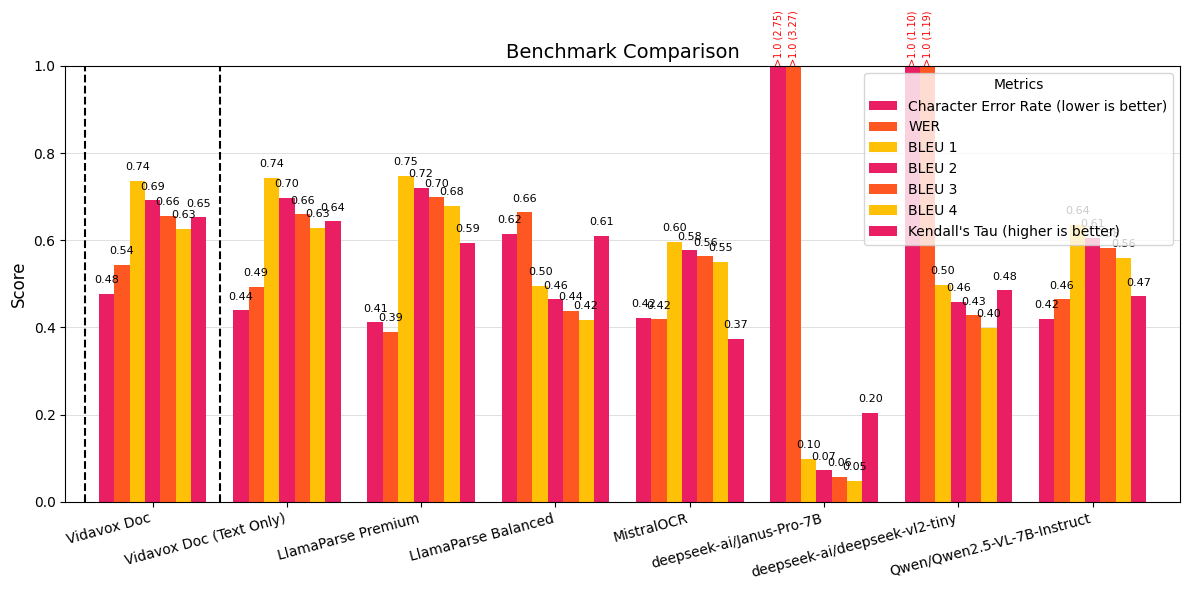

In [33]:
# Filter for models shown in the image
# NOTE: Make sure the index names in df_transposed exactly match these strings
models_to_plot = ['Vidavox Doc', 'Vidavox Doc (Text Only)', 'LlamaParse Premium', 'LlamaParse Balanced', 'MistralOCR', 'deepseek-ai/Janus-Pro-7B', 'deepseek-ai/deepseek-vl2-tiny', 'Qwen/Qwen2.5-VL-7B-Instruct']
# Ensure only models present in the dataframe index are selected
models_available = [model for model in models_to_plot if model in df_transposed.index]
df_plot = df_transposed.loc[models_available]


# Rename columns for the legend (matching the image)
# Note: Ensure these column names exist in df_plot before renaming
df_plot = df_plot.rename(columns={
    'CER': 'Character Error Rate (lower is better)',
    'BLEU': 'BLEU Score (higher is better)',
    'Order Score (Kendall Tau)': "Kendall's Tau (higher is better)"
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6)) # Increased width slightly for more models

# Define colors - ensure enough colors for the number of metrics (columns)
# Using 3 colors for the 3 metrics
colors = ['#E91E63', '#FF5722', '#FFC107'] # Yellow/Orange, Orange/Red, Pink/Red

# --- Create the bar plot ---
# Use only the first n_metrics colors if more are provided
df_plot.plot(kind='bar', ax=ax, width=0.8, color=colors[:len(df_plot.columns)])

# --- Calculations for annotations and lines ---
n_models = len(df_plot.index)
n_metrics = len(df_plot.columns)
x = np.arange(n_models)  # the label locations (0, 1, 2...)
group_width = 0.8 # Corresponds to 'width' in df_plot.plot
bar_width = group_width / n_metrics

# --- Add Bar Value Labels ---
for i, model in enumerate(df_plot.index):
    for j, metric in enumerate(df_plot.columns):
        value = df_plot.loc[model, metric]
        # Calculate precise x-position for each bar's label
        bar_x_pos = x[i] - group_width / 2 + (j + 0.5) * bar_width
        # Only add label if the value is within the plotted range (0 to 1)
        if 0 <= value <= 1.0:
             ax.text(bar_x_pos, value + 0.02, f'{value:.2f}', # Format to 2 decimal places
                     ha='center', va='bottom', fontsize=8, color='black') # Reduced fontsize slightly
        # Optional: Add a marker or different label for clipped bars
        elif value > 1.0:
             ax.text(bar_x_pos, 1.0, f'>1.0 ({value:.2f})', # Indicate clipping and show actual value
                     ha='center', va='bottom', fontsize=7, color='red', rotation=90)


# --- Customize Appearance ---
# Title and Labels
# Updated title to reflect the models plotted
ax.set_title('Benchmark Comparison', fontsize=14) # More generic title
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('') # Remove x-axis label

# X-axis Ticks
ax.set_xticks(x)
# Rotate labels if they overlap
ax.set_xticklabels(df_plot.index, rotation=15, ha='right', fontsize=10)

# Y-axis Ticks and Limits
# *** THIS IS THE CORRECTED LINE ***
ax.set_ylim(0, 1.0) # Set y-axis limits from 0 to exactly 1.0
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2)) # Ticks every 0.2
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # Format y-ticks to 1 decimal place

# Gridlines (horizontal)
ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
ax.set_axisbelow(True) # Keep grid behind bars

# Legend
# ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), fontsize=9) # Move legend outside

# Dashed Vertical Lines (Update to cover all gaps)
line_start_pos = x[0] - group_width / 2 - (1-group_width)/2 # Position before first group starts
ax.axvline(line_start_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)

# Calculate positions halfway between the centers of all adjacent groups
line_pos = (x[0] + x[0+1]) / 2
ax.axvline(line_pos, color='black', linestyle='--', linewidth=1.5, ymin=0.0, ymax=1.0)

# Adjust layout and display
plt.tight_layout() # Adjust rect to make space for external legend
plt.show()